In [19]:
import time
import json  # for checkpointing
import csv

from pathlib import Path

import numpy as np
import scipy.sparse
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

import pandas as pd

import datetime

import os
from dotenv import load_dotenv, find_dotenv

from timeit import default_timer as timer

load_dotenv(find_dotenv('config.env'))

torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.get_device_name(0)
torch.cuda.is_available()

True

In [20]:
!nvidia-smi

Mon Mar 22 21:47:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 457.51       Driver Version: 457.51       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   35C    P8    10W / 151W |   1380MiB /  8192MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
ticks_tiles_newlined = [
    "1\nman",
    "2\nman",
    "3\nman",
    "4\nman",
    "5\nman",
    "6\nman",
    "7\nman",
    "8\nman",
    "9\nman",
    "1\npin",
    "2\npin",
    "3\npin",
    "4\npin",
    "5\npin",
    "6\npin",
    "7\npin",
    "8\npin",
    "9\npin",
    "1\nsou",
    "2\nsou",
    "3\nsou",
    "4\nsou",
    "5\nsou",
    "6\nsou",
    "7\nsou",
    "8\nsou",
    "9\nsou",
    "\nEast",
    "\nSouth",
    "\nWest",
    "\nNorth",
    "\nHaku",
    "\nHatsu",
    "\nChun"
]

ticks_tiles_oneline = [
    "1 man",
    "2 man",
    "3 man",
    "4 man",
    "5 man",
    "6 man",
    "7 man",
    "8 man",
    "9 man",
    "1 pin",
    "2 pin",
    "3 pin",
    "4 pin",
    "5 pin",
    "6 pin",
    "7 pin",
    "8 pin",
    "9 pin",
    "1 sou",
    "2 sou",
    "3 sou",
    "4 sou",
    "5 sou",
    "6 sou",
    "7 sou",
    "8 sou",
    "9 sou",
    "East",
    "South",
    "West",
    "North",
    "Haku",
    "Hatsu",
    "Chun"
]

In [22]:
##############################################
# PARAMETERS
##############################################
torch.manual_seed(0)
np.random.seed(0)

DEVICE = torch.device("cuda")
EPOCHS = 20
DATASET_CONFIG = 'testing'
SHUFFLE_DATASET = True

if DEVICE.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0) / 1024 ** 3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0) / 1024 ** 3, 1), 'GB')

GeForce GTX 1070
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [23]:
##############################################
# CLASSES
##############################################


class DiscardDataset(torch.utils.data.Dataset):

    def __init__(self, data_path, n_rows: int = None, years: list = None, reverse=False, phase: int = None, balance_data: bool = False):

        # If n_rows = None -> get all

        if n_rows:
            print(f"Loading Dataset with {n_rows} rows", end=' ')
        else:
            print(f"Loading Dataset with all rows", end=' ')

        if phase in [0, 1, 2]:
            print(f"(Phase {phase})", end='')
        else:
            print(f"(All Phases)", end='')
        print()

        paths = list(Path(data_path).iterdir())
        if reverse:
            paths.reverse()

        loaded_rows = 0
        temp_matrices = []
        paths_load_bar = tqdm(total=n_rows, unit='rows', position=0)
        for idx, path in enumerate(paths):

            arr = scipy.sparse.load_npz(path)

            if phase is not None and phase in [0, 1, 2]:
                phased_matrices = self.generate_phase_column(arr.toarray())
                arr = phased_matrices[phase]

            loaded_rows += arr.shape[0]

            temp_matrices.append(arr)

            paths_load_bar.set_postfix(files_loaded=(idx + 1))  # Update Bar

            if n_rows and n_rows <= loaded_rows:
                break

            paths_load_bar.update(arr.shape[0])

        if 1 < len(temp_matrices):
            arr = scipy.sparse.vstack(temp_matrices, format='csr', dtype=np.int8)
        else:
            arr = temp_matrices[0]

        # Due to the option to filter phases, the array is sometimes not of type np.ndarray
        if type(arr) is not np.ndarray:
            arr = arr.toarray()

        if n_rows:
            arr = arr[:n_rows]

        # Finalize tqdm bar
        paths_load_bar.n = arr.shape[0]
        paths_load_bar.last_print_n = arr.shape[0]
        paths_load_bar.refresh()
        paths_load_bar.close()

        if balance_data:
            counts = np.bincount(arr[:, -1], minlength=34)
            lowest_class_representation = np.argmin(counts)
            baseline_count = counts[lowest_class_representation]
            indices = np.argsort(arr[:, -1])
            arr_temp = arr[indices]
            net = np.array_split(arr_temp, np.where(np.diff(arr_temp[:, -1])!=0)[0]+1)
            for i in range(len(net)):
                net[i] = net[i][:baseline_count]

            arr = np.concatenate(net, axis=0)

        self.x_data = torch.FloatTensor(arr[:, :-1])  # Must be Float it seems
        self.y_data = torch.LongTensor(arr[:, -1])  # Must be Long it seems

    @staticmethod
    def generate_phase_column(array: np.array) -> np.array:
        # Begin with merging all pools together

        merged_discards = array[:, 238:]  # Discards
        merged_discards = np.sum(merged_discards, axis=1)

        phases = np.zeros([array.shape[0]])  # Early Game
        phases[(24 < merged_discards) & (merged_discards <= 48)] = 1  # Mid Game
        phases[(48 < merged_discards)] = 2  # End Game

        return array[(phases == 0)], array[(phases == 1)], array[(phases == 2)]

    def __len__(self):
        return self.x_data.shape[0]

    def __getitem__(self, idx):
        return {
            'X': self.x_data[idx],
            'y': self.y_data[idx]
        }

# DATASET
```
# CONCATENATED DATASET EXAMPLE
train_dataset = torch.utils.data.ConcatDataset([
    DiscardDataset('data/2019_discard_dataset/', 1_000_000, phase=0),
    DiscardDataset('data/2019_discard_dataset/', 1_000_000, phase=1),
    DiscardDataset('data/2019_discard_dataset/', 1_000_000, phase=2)
])

test_dataset = torch.utils.data.ConcatDataset([
    DiscardDataset('data/2019_discard_dataset/', 1_000, phase=0, reverse=True),
    DiscardDataset('data/2019_discard_dataset/', 1_000, phase=1, reverse=True),
    DiscardDataset('data/2019_discard_dataset/', 1_000, phase=2, reverse=True)
])
```

In [24]:
# Load from configurations
ds_configs = pd.read_csv('Dataset Configurations.csv', index_col='dataset_name')
selected_config = ds_configs.loc[DATASET_CONFIG]
selected_config

train_size          10000
test_size            1000
validation_split      0.2
batch                  32
phases                 -1
years_training          1
years_testing       10001
balanced_data       False
Name: testing, dtype: object

In [25]:
def get_years(code: int) -> list:
    found_years = []
    for i in range(11):
        if (code >> i) & 1:
            found_years.append(2019 - i)
    found_years.reverse()
    return found_years

get_years(0b01011111111)

[2010, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [26]:
print("\nLOADING DATASETS:\n")

# Get path
dataset_path = Path(os.environ.get('DISCARD_DATASET'))
BATCH_SIZE = int(selected_config['batch'])  # We must cast it or else it will crash

# Single-Phase Datasets
train_dataset = DiscardDataset(dataset_path / "2018", selected_config['train_size'], phase=selected_config['phases'], balance_data=True)

# Creating data indices for training and validation splits:  (Inspired from https://stackoverflow.com/a/50544887)
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(selected_config['validation_split'] * dataset_size))

if SHUFFLE_DATASET:
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating data samplers and loaders:
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)

# Test Dataset
test_dataset = DiscardDataset(dataset_path / "2019", selected_config['test_size'], phase=selected_config['phases'], reverse=True)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=SHUFFLE_DATASET)


LOADING DATASETS:

Loading Dataset with 10000 rows (All Phases)
Loading Dataset with 1000 rows (All Phases)


  0%|          | 0/10000 [00:00<?, ?rows/s]

  0%|          | 0/1000 [00:00<?, ?rows/s]

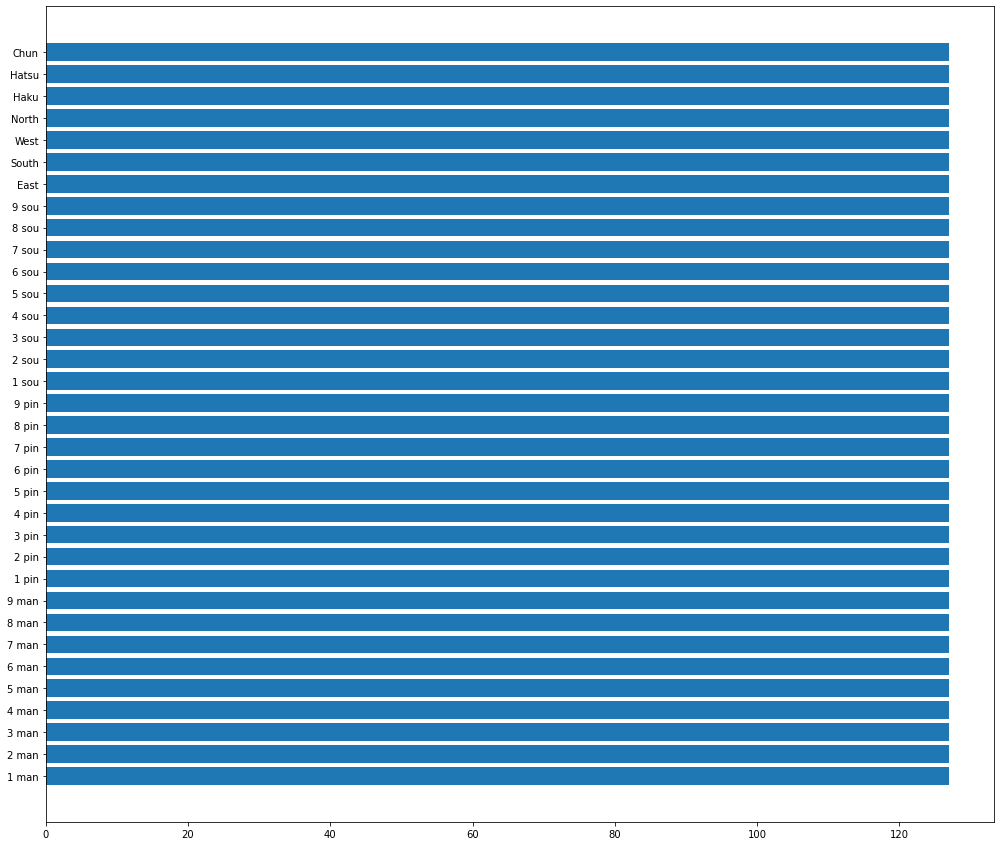

In [27]:
keys, counts = np.unique(train_dataset.y_data, return_counts=True)
fig = plt.figure(figsize=(17, 15))
ax = plt.gca()
plt.barh(keys, counts)

plt.yticks(range(34), ticks_tiles_oneline)
plt.show()

# Model Creation

## Basic Network

In [28]:
class Net(torch.nn.Module):
    """ Simple Feed-Forward Net """

    def __init__(self):
        super(Net, self).__init__()
        
        self.name = "BasicDenseNetwork_testing"
        
        self.fc1 = torch.nn.Linear(11 * 34, 1028)
        self.fc2 = torch.nn.Linear(1028, 512)
        self.fc3 = torch.nn.Linear(512, 256)
        self.fc4 = torch.nn.Linear(256, 128)
        self.fc5 = torch.nn.Linear(128, 34)
        
        self.relu_1 = torch.nn.LeakyReLU()
        self.relu_2 = torch.nn.LeakyReLU()
        self.relu_3 = torch.nn.LeakyReLU()
        self.relu_4 = torch.nn.LeakyReLU()

        
#         self.dropout_1 = torch.nn.Dropout()
#         self.dropout_2 = torch.nn.Dropout()
#         self.dropout_3 = torch.nn.Dropout()
#         self.dropout_4 = torch.nn.Dropout()


    def forward(self, x):
        x = self.fc1(x)
        x = self.relu_1(x)
        
        x = self.fc2(x)
        x = self.relu_2(x)
        
        x = self.fc3(x)
        x = self.relu_3(x)
        
        x = self.fc4(x)
        x = self.relu_4(x)
        
        x = self.fc5(x)

        return x

    
model = Net().to(DEVICE)
criterion = torch.nn.CrossEntropyLoss().to(DEVICE)  # Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

loaded_epoch = 0

model

Net(
  (fc1): Linear(in_features=374, out_features=1028, bias=True)
  (fc2): Linear(in_features=1028, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=34, bias=True)
  (relu_1): LeakyReLU(negative_slope=0.01)
  (relu_2): LeakyReLU(negative_slope=0.01)
  (relu_3): LeakyReLU(negative_slope=0.01)
  (relu_4): LeakyReLU(negative_slope=0.01)
)

In [29]:
LOAD_FOLDER = 'heavy_training_2021-03-21'  # Change this if you want to LOAD or NOT

# TO LOAD OR NOT LOAD
if LOAD_FOLDER:
    CHECKPOINT_PATH = Path('model_checkpoints') / LOAD_FOLDER
    DESCRIPTION_PATH = CHECKPOINT_PATH / 'description.json'
    SUMMARY_PATH = CHECKPOINT_PATH / 'summary.csv'

    last_epoch_file = sorted([c for c in CHECKPOINT_PATH.iterdir() if c.suffix == '.pt'])[-1]
    loaded_checkpoint = torch.load(last_epoch_file)
    print('Loaded Epoch', loaded_checkpoint['epoch'])

    model.load_state_dict(loaded_checkpoint['model_state'])
    optimizer.load_state_dict(loaded_checkpoint['optimizer_state'])
    loaded_epoch = loaded_checkpoint['epoch']

else:
    # Create Model Checkpoint Folder
    timestamp_string = time.strftime('%Y-%m-%d_%H-%M', time.localtime(time.time()))
    CHECKPOINT_PATH = Path('model_checkpoints') / f"{timestamp_string}_{model.name}"
    CHECKPOINT_PATH.mkdir()

    DESCRIPTION_PATH = CHECKPOINT_PATH / 'description.json'
    SUMMARY_PATH = CHECKPOINT_PATH / 'summary.csv'

    model_desc_json = {
        'model_name': model.name,
        'model_description': repr(model),
        'dataset_config': repr(selected_config)
    }

    with open(DESCRIPTION_PATH, 'w') as outfile:
        json.dump(model_desc_json, outfile)

    with open(SUMMARY_PATH, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc", "time_elapsed"])

Loaded Epoch 9


# TRAINING & VALIDATION

In [26]:
def seconds_to_hhmmss(s):
    seconds = s
    minutes = seconds // 60
    hours = minutes // 60
    return "%02d:%02d:%02d" % (hours, minutes % 60, seconds % 60)

In [27]:
if loaded_epoch != 0:
    loaded_epoch += 1  # If epoch was loaded

# Progress Bars
mq = trange(EPOCHS, desc='EPOCH', unit='epoch', initial=loaded_epoch)
tq = trange(len(train_loader), desc=f'TRAINING', unit='batch')
vq = trange(len(validation_loader), desc=f'VALIDATION', unit='batch')

for epoch in range(loaded_epoch, EPOCHS):
    
    torch.manual_seed(epoch)
    start_timer = timer()  # Start timer

    
    ##############################################
    # TRAINING
    ##############################################
    sum_epoch_loss = 0.0
    sum_epoch_acc = 0.0

    model.train()
    for batch_idx, batch in enumerate(train_loader):
        X = batch['X'].to(DEVICE)
        y = batch['y'].to(DEVICE)

        optimizer.zero_grad()

        outputs = model(X)  # Outputs float values for each class (do softmax on `outputs` to get distribution)
        
        # CUSTOM LOSS IN THE MAKING
#         hand_rows = X[:, 2*34:3*34]
#         sx = (hand_rows == 0)
#         sx = sx.double()
#         ss = sx * 1.1
#         ss += 1  # True => X, False => 1
#         augmented = outputs * ss
        loss = criterion(outputs, y)  # avg loss in batch -> No need for softmax if criterion = Cross Entropy Loss
        
        predictions = torch.argmax(outputs, dim=1)
        num_correct_predictions = torch.sum(torch.eq(predictions, y)).item()
        batch_acc = num_correct_predictions / y.shape[0]  # y.shape[0] = batch_size

        sum_epoch_loss += loss.item()
        sum_epoch_acc += batch_acc

        loss.backward()  # compute gradients
        optimizer.step()  # update weights
        
        tq.update(1)
    
    tq.refresh()
    time.sleep(0.1)
    avg_acc_train = sum_epoch_acc / len(train_loader)  # average accuracy
    avg_loss_train = sum_epoch_loss / len(train_loader)  # average loss

    ##############################################
    # VALIDATION
    ##############################################
    sum_epoch_loss = 0.0
    sum_epoch_acc = 0.0
    
    model.eval()
    for batch_idx, batch in enumerate(validation_loader):
        X = batch['X'].to(DEVICE)
        y = batch['y'].to(DEVICE)

        # optimizer.zero_grad()  # TODO: Needed?

        with torch.no_grad():  # Disables tracking of gradient
            outputs = model(X)
        loss = criterion(outputs, y)  # avg loss in batch

        predictions = torch.argmax(outputs, dim=1)
        num_correct_predictions = torch.sum(torch.eq(predictions, y)).item()
        batch_acc = num_correct_predictions / y.shape[0]  # y.shape[0] = batch_size

        sum_epoch_loss += loss.item()
        sum_epoch_acc += batch_acc
        
        vq.update(1)
    
    vq.refresh()
    time.sleep(0.1)
    avg_acc_val = sum_epoch_acc / len(validation_loader)  # average accuracy
    avg_loss_val = sum_epoch_loss / len(validation_loader)  # average loss
    
    ##############################################
    # EPOCH CLEAN-UP
    ##############################################
    elapsed_time = timer() - start_timer  # End Timer
    
    # Print Epoch Summary
    print('EPOCH {:>2}  |  TRAIN: loss={:.3f}, acc={:5.3f}  |  VALIDATION: loss={:.3f}, acc={:5.3f}  | TIME ELAPSED: {}'
          .format(epoch,
                  avg_loss_train, 
                  avg_acc_train,   
                  avg_loss_val, 
                  avg_acc_val,
                  seconds_to_hhmmss(elapsed_time),
                 ))
    
    # Save Epoch Summary to csv
    with open(SUMMARY_PATH, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            epoch, 
            avg_loss_train,
            avg_acc_train,
            avg_loss_val,
            avg_acc_val,
            seconds_to_hhmmss(elapsed_time)
        ])

    # Checkpoint Creation
    training_checkpoint = {
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'epoch': epoch,
#         'train_acc': avg_acc_train,
#         'train_loss': avg_loss_train,
#         'val_acc': avg_acc_val,
#         'val_loss': avg_loss_val
    }
#     destination = CHECKPOINT_PATH / (f'epoch-{epoch:03}-val_loss-{avg_loss_val:.3f}.pt')
    destination = CHECKPOINT_PATH / (f'epoch-{epoch:03}.pt')
    torch.save(training_checkpoint, destination)
    
    # Progress Bar Clean-up
    mq.update(1)
    tq.reset()
    vq.reset()

EPOCH:   0%|          | 0/20 [00:00<?, ?epoch/s]

TRAINING:   0%|          | 0/2000000 [00:00<?, ?batch/s]

VALIDATION:   0%|          | 0/500000 [00:00<?, ?batch/s]

EPOCH  0  |  TRAIN: loss=3.183, acc=0.101  |  VALIDATION: loss=2.860, acc=0.195  | TIME ELAPSED: 01:19:16
EPOCH  1  |  TRAIN: loss=2.774, acc=0.182  |  VALIDATION: loss=2.591, acc=0.236  | TIME ELAPSED: 01:19:06
EPOCH  2  |  TRAIN: loss=2.509, acc=0.242  |  VALIDATION: loss=2.461, acc=0.272  | TIME ELAPSED: 01:18:47
EPOCH  3  |  TRAIN: loss=2.317, acc=0.292  |  VALIDATION: loss=2.216, acc=0.332  | TIME ELAPSED: 01:18:50
EPOCH  4  |  TRAIN: loss=2.170, acc=0.333  |  VALIDATION: loss=1.894, acc=0.396  | TIME ELAPSED: 01:18:25
EPOCH  5  |  TRAIN: loss=1.981, acc=0.379  |  VALIDATION: loss=1.796, acc=0.414  | TIME ELAPSED: 01:19:08
EPOCH  6  |  TRAIN: loss=1.867, acc=0.406  |  VALIDATION: loss=2.129, acc=0.342  | TIME ELAPSED: 01:19:29
EPOCH  7  |  TRAIN: loss=1.768, acc=0.429  |  VALIDATION: loss=1.671, acc=0.457  | TIME ELAPSED: 01:19:42
EPOCH  8  |  TRAIN: loss=1.724, acc=0.441  |  VALIDATION: loss=1.704, acc=0.447  | TIME ELAPSED: 01:19:50
EPOCH  9  |  TRAIN: loss=1.663, acc=0.457  |  

KeyboardInterrupt: 

# Model TESTING

In [78]:
def check_if_tile_in_hand(predicted_class, data) -> bool:
    """ Return True if predicted class is in hand. """
    return data[0][68:102][predicted_class] != 0

In [82]:
print('\nTESTING')

torch.manual_seed(0)


n_correct = 0
n_wrong = 0

n_invalid_discards = 0
predictions = []
targets = []

model.eval()
for batch_idx, batch in enumerate(tqdm(test_loader, total=len(test_loader), desc=f'Testing', unit='batch')):

    X = batch['X'].to(DEVICE)
    y = batch['y'].to(DEVICE)
    
    optimizer.zero_grad()
    with torch.no_grad():
        output = model(X)

#     outputs.append(output)  # 34-lengthed tensor

    big_idx = torch.argmax(output)
    if big_idx == y:
        n_correct += 1
    else:
        n_wrong += 1
        
    # Invalid Discards
    if not check_if_tile_in_hand(big_idx, X):
        n_invalid_discards += 1
        
    # Confusion Matrix
    predictions.append(big_idx.item())
    targets.append(y.item())

time.sleep(0.5)
acc = n_correct / (n_correct + n_wrong)
print("Testing Accuracy:", acc)

print("Number of Invalid Discards: {}".format(n_invalid_discards))
print("Invalid Discards Percentage: {}".format(n_invalid_discards / len(test_loader)))


TESTING


Testing:   0%|          | 0/1000000 [00:00<?, ?batch/s]

Testing Accuracy: 0.476843
Number of Invalid Discards: 7273
Invalid Discards Percentage: 0.007273


In [31]:
import sklearn.metrics
print(sklearn.metrics.classification_report(targets, predictions, digits=3, zero_division=1))

              precision    recall  f1-score   support

           0      0.479     0.716     0.574     40699
           1      0.480     0.515     0.497     27612
           2      0.403     0.429     0.415     19094
           3      0.399     0.364     0.381     16347
           4      0.355     0.248     0.292     14483
           5      0.368     0.384     0.376     16046
           6      0.525     0.337     0.411     19207
           7      0.490     0.470     0.480     27411
           8      0.465     0.685     0.554     40577
           9      0.634     0.465     0.536     40446
          10      0.526     0.330     0.405     27872
          11      0.482     0.385     0.428     19761
          12      0.470     0.304     0.369     16488
          13      0.580     0.143     0.230     14452
          14      0.538     0.250     0.341     16242
          15      0.506     0.392     0.442     19518
          16      0.579     0.392     0.468     27777
          17      0.550    

# Resources


# Target Distribution

In [ ]:
keys, counts = np.unique([data['y'].item() for data in DiscardDataset(dataset_path / "2019", n_rows=None, phase=-1, reverse=False)], return_counts=True)
plt.figure(figsize=(17, 15))
plt.barh(keys, counts)
plt.yticks(range(34), ticks_tiles_oneline)
plt.show()

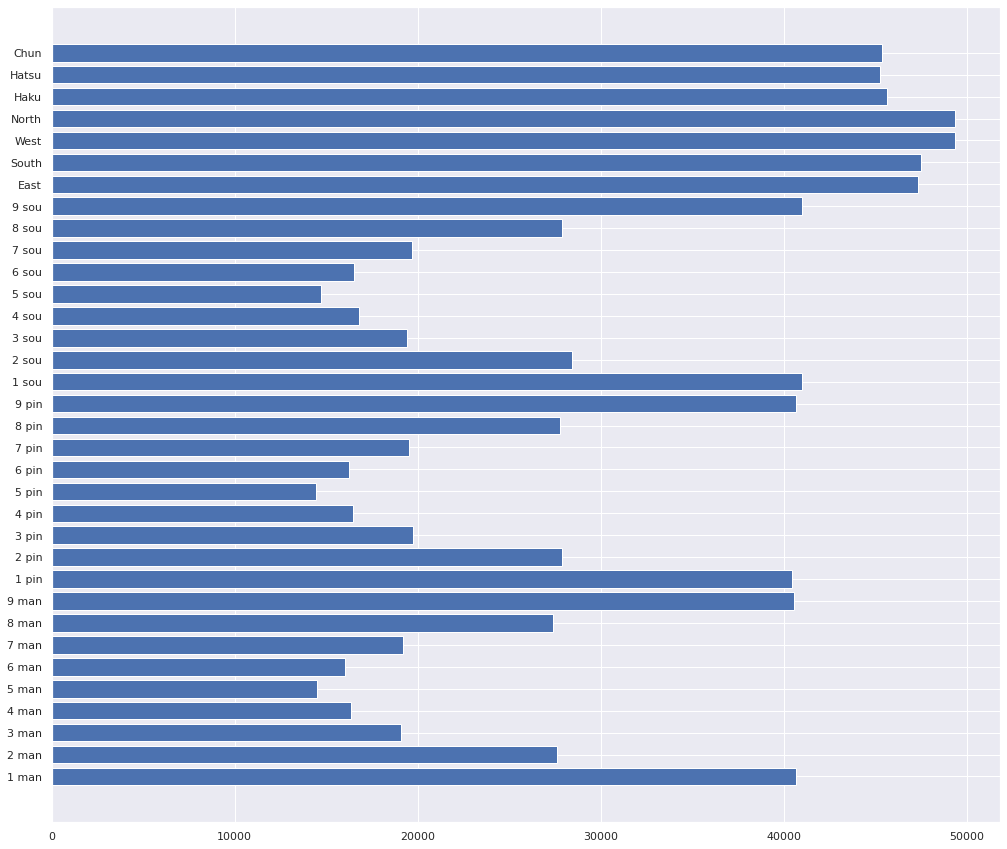

In [41]:
keys, counts = np.unique([data['y'].item() for data in test_dataset], return_counts=True)
plt.figure(figsize=(17, 15))
plt.barh(keys, counts)
plt.yticks(range(34), ticks_tiles_oneline)
plt.show()

# Prediction Distribution

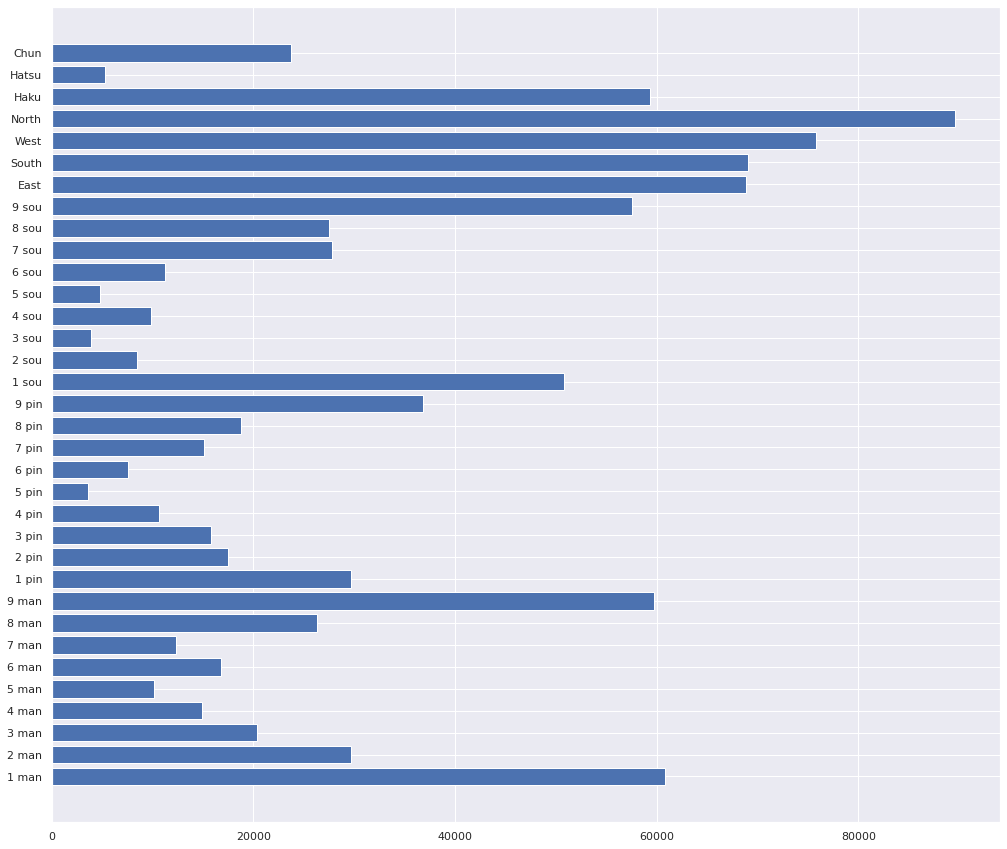

In [42]:
keys, counts = np.unique(predictions, return_counts=True)
fig = plt.figure(figsize=(17, 15))
ax = plt.gca()
plt.barh(keys, counts)

plt.yticks(range(34), ticks_tiles_oneline)
plt.show()

In [43]:
import sklearn
import pandas as pd
import seaborn as sns

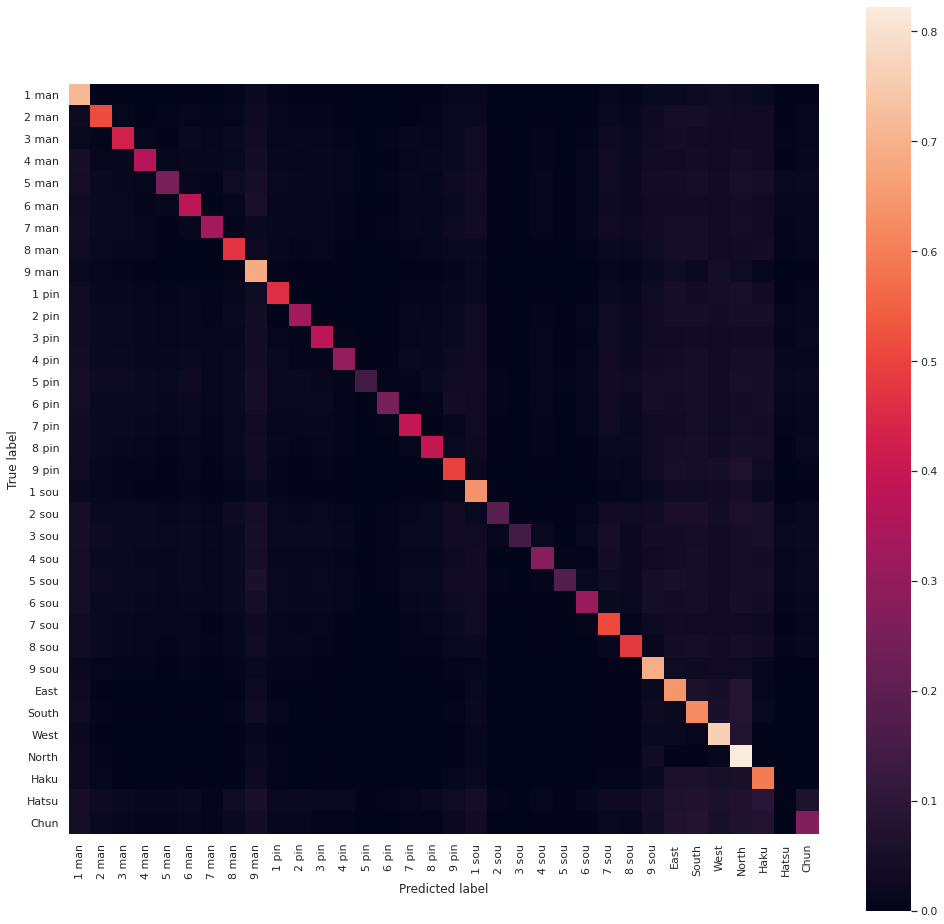

In [44]:
confusion_nparray = sklearn.metrics.confusion_matrix(targets, predictions, normalize='true')
df_cm = pd.DataFrame(confusion_nparray)
plt.figure(figsize=(14, 13))
sns.set(font_scale=1) # for label size
sns.heatmap(df_cm, annot=False, annot_kws={"size": 10}, square=True, xticklabels=ticks_tiles_oneline, yticklabels=ticks_tiles_oneline) # font size

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

In [45]:
summary = pd.read_csv(SUMMARY_PATH, index_col='epoch')
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   train_loss    10 non-null     float64
 1   train_acc     10 non-null     float64
 2   val_loss      10 non-null     float64
 3   val_acc       10 non-null     float64
 4   time_elapsed  10 non-null     object 
dtypes: float64(4), object(1)
memory usage: 480.0+ bytes


In [46]:
# sns.set_style("ticks")
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
# sns.set_style("whitegrid")
sns.set_style("darkgrid")

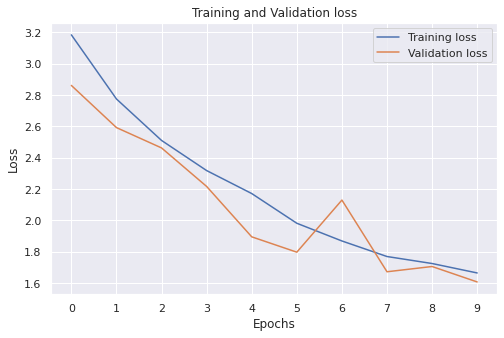

In [50]:
loss_train = summary['train_loss']
loss_val = summary['val_loss']
epochs = summary.index

figure = plt.figure(figsize=(8, 5))

plt.xticks(list(summary.index))

plt.plot(epochs, loss_train, label='Training loss')
plt.plot(epochs, loss_val, label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [49]:
# plt.figure(figsize=(8, 5))

# plt.xticks(list(summary.index))
# plt.yticks(np.arange(0, 1.1, 0.1))
# plt.ylim(0, 1)

# plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')

# sns.lineplot(
#     data=summary[['train_acc', 'val_acc']], dashes=False
# )

# plt.show()

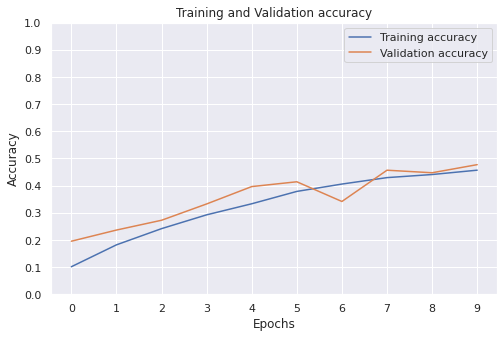

In [48]:
loss_train = summary['train_acc']
loss_val = summary['val_acc']
epochs = list(summary.index)

figure = plt.figure(figsize=(8, 5))

plt.xticks(list(summary.index))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1)

plt.plot(epochs, loss_train, label='Training accuracy')
plt.plot(epochs, loss_val, label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()